# Sistema de Recomendações

In [1]:
from lenskit.datasets import ML100K
from lenskit import batch, topn, util
from lenskit import crossfold as xf
from lenskit.algorithms import Recommender, als, item_knn as knn
from lenskit import topn
import pandas as pd

In [4]:
ml100k = ML100K('data\ml-100k')
ratings = ml100k.ratings
ratings.head()

,user,item,rating,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596


In [5]:
algo_ii = knn.ItemItem(20)
algo_als = als.BiasedMF(50)

In [6]:
def eval(aname, algo, train, test):
    fittable = util.clone(algo)
    fittable = Recommender.adapt(fittable)
    fittable.fit(train) #this is the fit model
    users = test.user.unique()
    # now we run the recommender
    recs = batch.recommend(fittable, users, 100) #movies to be recommended
    # add the algorithm name for analyzability
    recs['Algorithm'] = aname
    return recs

In [7]:
all_recs = [] #all recomendation
test_data = []
for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    test_data.append(test)
    all_recs.append(eval('ItemItem', algo_ii, train, test)) #algorithm itemitem
    all_recs.append(eval('ALS', algo_als, train, test)) #algorithm als

Numba is using threading layer omp - consider TBB
BLAS using multiple threads - can cause oversubscription
found 2 potential runtime problems - see https://boi.st/lkpy-perf


In [8]:
all_recs = pd.concat(all_recs, ignore_index=True)
all_recs.head()

,item,score,user,rank,Algorithm
0,603,4.670764,6,1,ItemItem
1,1449,4.621164,6,2,ItemItem
2,483,4.615537,6,3,ItemItem
3,615,4.428878,6,4,ItemItem
4,60,4.422771,6,5,ItemItem


In [9]:
test_data = pd.concat(test_data, ignore_index=True)

In [10]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.ndcg)
results = rla.compute(all_recs, test_data)
results.head()

nrecs      ndcg
Algorithm user                 
ItemItem  6       100  0.335651
          8       100  0.069414
          29      100  0.053572
          38      100  0.074123
          44      100  0.107154

In [11]:
results.groupby('Algorithm').ndcg.mean()

Algorithm
ALS         0.134534
ItemItem    0.102051
Name: ndcg, dtype: float64

<AxesSubplot:xlabel='Algorithm'>

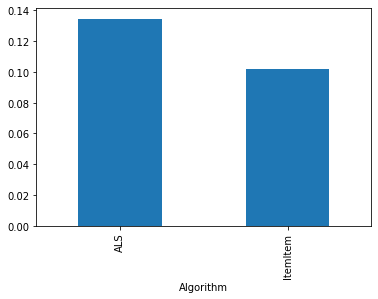

In [12]:
results.groupby('Algorithm').ndcg.mean().plot.bar()

In [13]:
fittable = util.clone(algo_als)
fittable = Recommender.adapt(fittable)
fittable.fit(train) #this is the fit model

In [14]:
from tempfile import mkdtemp
savedir = mkdtemp()
import os
filename = os.path.join(savedir, 'test.joblib')

In [15]:
to_persist = fittable

In [16]:
import joblib
joblib.dump(to_persist, filename)  

['C:\\Users\\jaque\\AppData\\Local\\Temp\\tmpivuzhwe2\\test.joblib']

In [17]:
joblib.load(filename)

In [18]:
users = ml100k.users
users.head()

,age,gender,occupation,zip
user,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [19]:
movies = ml100k.movies
movies.head()

,title,release,vidrelease,imdb,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
item,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
